## Racist Deeds Proof of Concept

### Extracting Ground Truth Text

This steps assumes you have two directories in the same directory as this notebook:
- ./racist_deeds_text
- ./non_racist_deeds_text

You can access the racist deeds text [here](https://drive.google.com/drive/folders/1bo3TJqgnqVh4MsmqCGEjeH_ms9QbRoCf?usp=drive_link).
You can access the non-racist deeds text [here](https://drive.google.com/drive/folders/10EEBMFT63pTTlpGvVr_Se-XN2Dvl1hHs?usp=drive_link)

Run the following script to extract the deed text into a dataframe with a column for is_racist:

In [2]:
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append('../deed_preprocessing')
from preprocessor import preprocess_text
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def preprocess_deeds():
    sys.path.append('../deed_preprocessing')
    from preprocessor import preprocess_text

    racist_dir = Path('./racist_deeds_text')
    non_racist_dir = Path('./non_racist_deeds_text')

    all_data = pd.DataFrame()

    racist_count = 0
    non_racist_count = 0

    def process_directory(directory, is_racist_label):
        nonlocal all_data, racist_count, non_racist_count
        for file in directory.iterdir():
            if file.is_file() and file.suffix == '.txt':
                with file.open('r', encoding='utf-8') as f:
                    text = f.read()
                    processed_text = preprocess_text(text)

                    df = pd.DataFrame([processed_text])
                    df['is_racist'] = is_racist_label

                    all_data = pd.concat([all_data, df], ignore_index=True)

                if is_racist_label == 1:
                    racist_count += 1
                else:
                    non_racist_count += 1

    process_directory(racist_dir, 1)
    process_directory(non_racist_dir, 0)

    print(f"Number of racist text files read: {racist_count}")
    print(f"Number of non-racist text files read: {non_racist_count}")

    return all_data


preprocessed_data = preprocess_deeds()
preprocessed_data.to_pickle('preprocessed_deeds.pkl')

Number of racist text files read: 61
Number of non-racist text files read: 750


### Establishing a Baseline with Bag of Words and Logistic Regression

The following code runs bag of words and logistic regression on the ground truth dataset of 750 non-racist deeds, and 61 racist deeds.

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        16

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



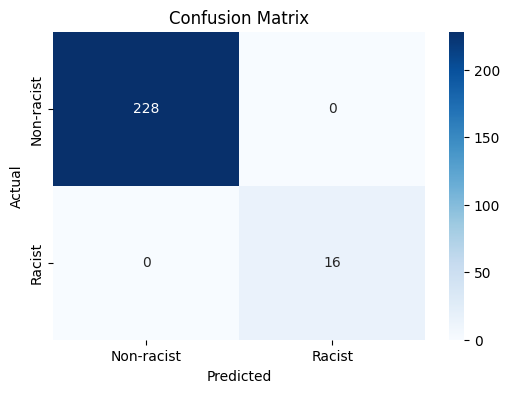

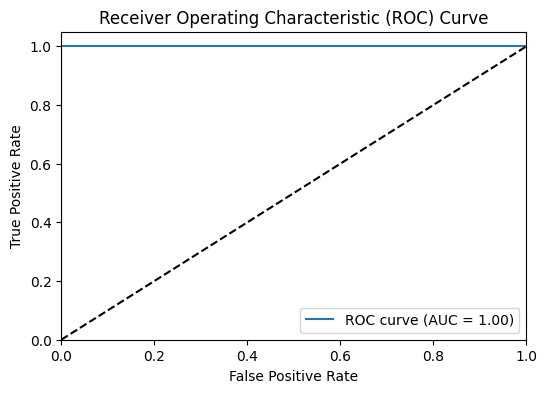

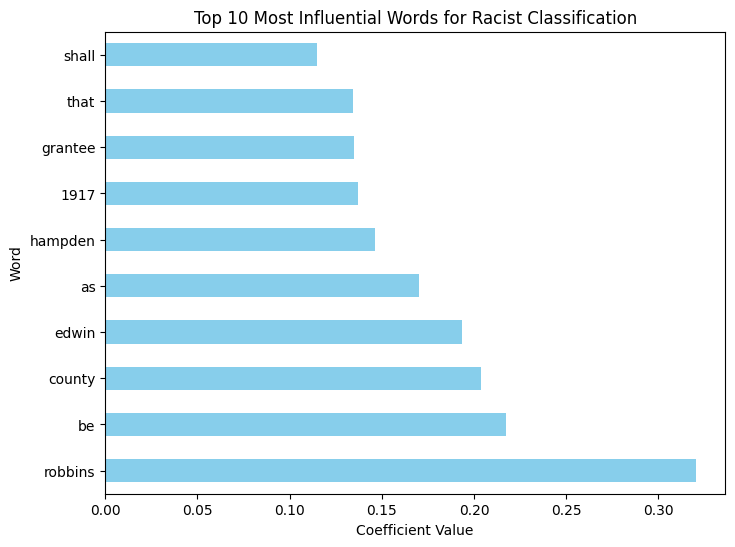

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_bag_of_words(preprocessed_text_list):
    texts = [preprocessed["original_text"] for preprocessed in preprocessed_text_list]
    
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(texts)

    bow_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())

    return bow_df, vectorizer

preprocessed_data = pd.read_pickle('preprocessed_deeds.pkl')

texts = preprocessed_data['original_text']
preprocessed_text_list = texts.apply(lambda x: {"original_text": x}).tolist()

bow_df, vectorizer = preprocess_bag_of_words(preprocessed_text_list)

X = bow_df
y = preprocessed_data['is_racist']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-racist', 'Racist'], yticklabels=['Non-racist', 'Racist'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

feature_importance = pd.Series(logistic_model.coef_[0], index=vectorizer.get_feature_names_out())
top_features = feature_importance.nlargest(10)

plt.figure(figsize=(8, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Influential Words for Racist Classification')
plt.xlabel('Coefficient Value')
plt.ylabel('Word')
plt.show()


As shown in the graphs, a simple bag of words and logistic regression model achieves 100% accuracy on the ground truth data we have. Upon further examination, we can see that the model is using the name of a grantor, Edwin Robbins of Hampden County, to categorize a deed as racist or otherwise. It just so happens that all the deeds in our ground truth were issued by Edwin Robbins and contained racist language. It is interesting that we can attribute all these racist deeds to a single person, but the model will generalize poorly, so we will need to engineer features to circumvent this issue.

### Training a LSTM (Long Short Term Memory) NN Model to Classify Data

Step 1: Data Loading and Preprocessing

- Converts words to integer sequences using the top 10,000 most common words, assigning out-of-vocabulary words a special <OOV> token.
- Sequencing: Turns each text into a sequence of integers based on word indices.
- Padding: Pads sequences to a uniform length of 200 tokens, ensuring consistent input shape for models.

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

preprocessed_data = pd.read_pickle('preprocessed_deeds.pkl')

texts = preprocessed_data['original_text']
labels = preprocessed_data['is_racist']

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

max_length = 200  
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

Step 2: Glove Embeddings 

(Need to retrieve glove.6B.100d.txt from https://nlp.stanford.edu/projects/glove/ and find the "Pre-trained word vectors" section and download the glove.6B.zip file)

Load GloVe embeddings: Reads GloVe embeddings from glove.6B.100d.txt, which contains 100-dimensional vector representations of words.

Embedding Matrix Creation: Constructs an embedding matrix to map each word in the vocabulary to its corresponding GloVe vector.

In [3]:
# Load GloVe embeddings 
embedding_dim = 100
embeddings_index = {}
with open("glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create the embedding matrix for words in our vocabulary
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


Step 3: LSTM Model Architecture

Embedding Layer: The model's first layer is an embedding layer initialized with the GloVe embeddings to capture word semantics.

LSTM Layers: Uses two LSTM layers for sequential processing, with a dropout layer in between to reduce overfitting.

Output Layer: The final layer has a sigmoid activation function to produce a binary classification output (1 for racist, 0 for non-racist).

Compile the model: Sets binary_crossentropy as the loss function, adam as the optimizer, and tracks accuracy as the performance metric.

In [4]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\jiany\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Step 4: Train

Train the model: Trains the model over 10 epochs on 70% of the data, using the remaining 30% for validation.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8146 - loss: 0.4532 - val_accuracy: 0.9344 - val_loss: 0.2337
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9273 - loss: 0.2490 - val_accuracy: 0.9344 - val_loss: 0.2104
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9217 - loss: 0.2266 - val_accuracy: 0.9344 - val_loss: 0.1486
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9313 - loss: 0.1610 - val_accuracy: 0.9508 - val_loss: 0.1126
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9479 - loss: 0.1111 - val_accuracy: 0.9426 - val_loss: 0.0993
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9633 - loss: 0.1064 - val_accuracy: 0.9713 - val_loss: 0.1019
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9683 - loss: 0.0819 - val_accuracy: 0.9590 - val_loss: 0.0862
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9605 - loss: 0.0816 - val_accuracy: 0.

Step 5: Evaluate model

Evaluate the model: Tests the model on the validation set and prints the test accuracy.

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9825 - loss: 0.0517
Test Accuracy: 0.98


Plot Training and Validation Curves: Plots accuracy and loss over epochs for both training and validation to visualize the model's performance.

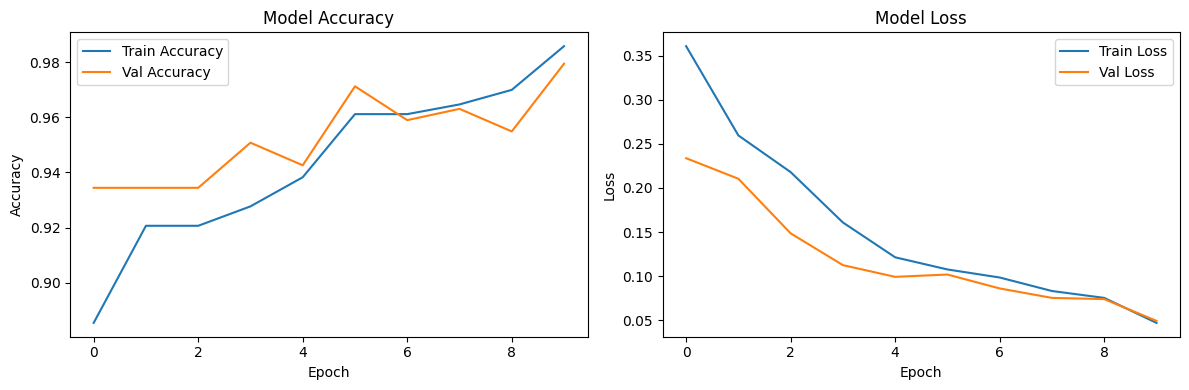

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


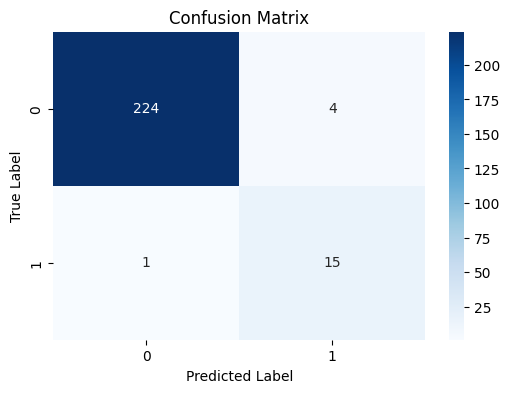

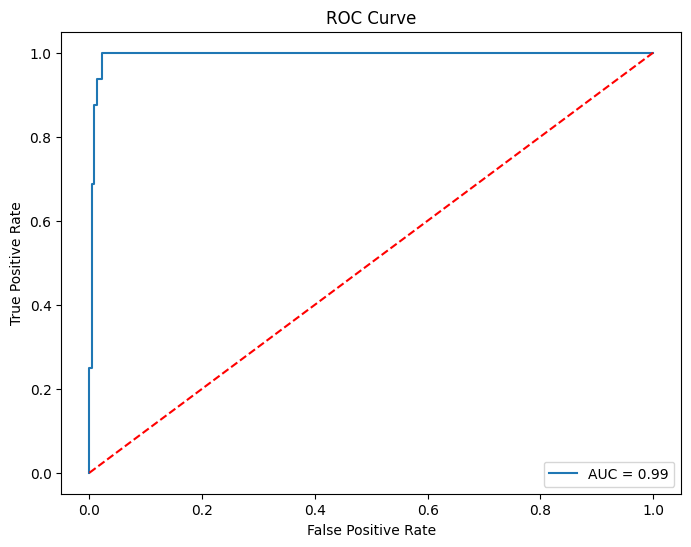

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


The LSTM model with GloVe embeddings processes each deed as a sequence of word meanings and learns to recognize patterns in sequences that are characteristic of racist language. Through training, it learns which combinations of words and phrases, along with their surrounding context, are more likely to indicate racism, allowing it to generalize to new texts. 

Looking at the model accuracy graph, the training and validation accuracy are increasing over time indicating that the model is learning effectively from the data. Same with the model loss graph where both training and validation are decreasing over time, showing that the model is fitting the training data well.

From the confusion matrix and the Roc curve, it shows that this model is 99% accurate. It mislabeled some racist deeds as non-racist and some non-racist deeds as racist deeds.

MODEL IS SUBJECT TO BIAS.


Testing to see if it detects deeds from the racist_deeds_text folder as racist and deeds from non_racist_deeds_text folder as non-racist. Can delete

In [14]:
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

racist_folder = 'racist_deeds_text'
non_racist_folder = 'non_racist_deeds_text'

# Function to load and preprocess text for prediction
def preprocess_text(text, tokenizer, max_length=200):
    # Convert text to a sequence of tokens
    sequence = tokenizer.texts_to_sequences([text])
    # Pad sequence to match the input shape of the model
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

# Function to predict if a deed is racist or non-racist
def predict_text(text, model, tokenizer):
    # Preprocess the text
    padded_sequence = preprocess_text(text, tokenizer)
    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]  # Get the predicted probability
    # Return binary classification (0 = Non-Racist, 1 = Racist)
    return int(prediction > 0.5)

# Function to test the model on all files in a folder and calculate accuracy
def test_folder(folder_path, label, model, tokenizer):
    correct_predictions = 0
    total_files = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            total_files += 1
            # Load text from file
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
            # Get model prediction
            prediction = predict_text(text, model, tokenizer)
            # Check if prediction matches the actual label
            if prediction == label:
                correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_files if total_files > 0 else 0
    return accuracy, total_files

# Test on racist and non-racist folders
racist_accuracy, racist_total = test_folder(racist_folder, label=1, model=model, tokenizer=tokenizer)
non_racist_accuracy, non_racist_total = test_folder(non_racist_folder, label=0, model=model, tokenizer=tokenizer)

# Print results
print(f"Racist Deeds - Accuracy: {racist_accuracy:.2f} ({racist_accuracy * racist_total}/{racist_total})")
print(f"Non-Racist Deeds - Accuracy: {non_racist_accuracy:.2f} ({non_racist_accuracy * non_racist_total}/{non_racist_total})")

# Calculate overall accuracy
total_accuracy = (racist_accuracy * racist_total + non_racist_accuracy * non_racist_total) / (racist_total + non_racist_total)
print(f"Overall Accuracy: {total_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━